This is going to be a fifa 19 ultimate team classifier, where the position of each ultimate team card will be estimated based on their basic stats. There are no correct answers, since players are not always borned to stay forever in the same position. Moreover, some players have more than 1 card (because there are special cards). This means that a specific player can have multiple positions from different cards. 

I am going to use a Support Vector Machine model (one vs all), using cross validation and I will also use the GridSearch in order to estimate the best parameters.

That being said, let's get started.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df_players_all = pd.read_csv('C:/Users/Notebook/Desktop/Kaggle/fifa/fifa_lista_jogadores.csv')


print(df_players_all.head())

print(df_players_all.tail())

   player_id player_name          player_extended_name      quality revision  \
0          1        Pelé      Arantes Nascimento Edson  Gold - Rare     Icon   
1          2    Maradona                Diego Maradona  Gold - Rare     Icon   
2          3     Ronaldo  Nazário de Lima Ronaldo Luís  Gold - Rare     Icon   
3          4        Pelé      Arantes Nascimento Edson  Gold - Rare     Icon   
4          5    Maradona                Diego Maradona  Gold - Rare     Icon   

   origin  overall   club league nationality   ...     ps4_max  ps4_prp  \
0   Prime       98  Icons  Icons      Brazil   ...    10300000       45   
1   Prime       97  Icons  Icons   Argentina   ...     5400000       52   
2   Prime       96  Icons  Icons      Brazil   ...    13000000       47   
3  Medium       95  Icons  Icons      Brazil   ...     6300000       50   
4  Medium       95  Icons  Icons   Argentina   ...     3700000       48   

  xbox_last  xbox_min  xbox_max  xbox_prp  pc_last  pc_min    pc_max

There are so many features. Each row corresponds to a card, and it has 95 features. For simplicity, I have chossen the features that are shown in the real card, since they represent the average of the attributes related. Those features are:

1- position 
2- pace 
3- dribbling 
4- shooting 
5- passing 
6- defending 
7- physicality 
8 - pref_foot 
9- overall 


Only the number 8 is not shown in the card, but it is important, since it shows a string correlation with the side of the field that the player actually plays.

In [3]:
df_players = df_players_all[['position', 'pace', 'dribbling', 'shooting', 'passing', 'defending', 'physicality', 'pref_foot', 'overall']].copy()


df_players_infos_add = df_players_all[['position', 'pace', 'dribbling', 'shooting', 'passing', 'defending', 'physicality', 'pref_foot', 'overall', 'player_name', 'club']].copy()


There is no point of trying to estimate the position of the goalie, since they have different attributes in their cards. This is why I am going to remove them.

In [4]:
df_players = df_players[df_players.position != 'GK']

df_players_infos_add = df_players_infos_add[df_players_infos_add.position != 'GK']



Moreover, since the strong foot is given by "right" or "left", I will change it to 1 and 0. By doing that we will be able to give some sense of distance between them. 

In [5]:
df_players['pref_foot'] = (df_players['pref_foot'] == "Right").astype(int)



Before we can continue, all the features (strong foot is not included) need to be normalized, because the players have different overalls.

In [6]:

df_players_normalized = df_players.copy(deep = False)



##df normalized
df_players_normalized['pace'] = df_players['pace']/(df_players['overall'])
df_players_normalized['dribbling'] = df_players['dribbling']/(df_players['overall'])
df_players_normalized['shooting'] = df_players['shooting']/(df_players['overall'])
df_players_normalized['defending'] = df_players['defending']/(df_players['overall'])
df_players_normalized['passing'] = df_players['passing']/(df_players['overall'])
df_players_normalized['physicality'] = df_players['physicality']/(df_players['overall'])




Now, let's see the number of players in each position

In [7]:
print(df_players_normalized['position'].value_counts())


CB     3146
ST     2871
CM     2290
CDM    1453
LB     1365
RB     1327
RM     1154
LM     1133
CAM    1072
LW      414
RW      398
CF      137
RWB      65
LWB      55
LF        1
RF        1
Name: position, dtype: int64


As we can see, there are some positions that are not really being used. Those are going to be seen as outleirs.

So, what we can do is to change some positions. For example, the only Lf player will be considered LW.

In [8]:
df_players_normalized['position'] = df_players_normalized['position'].str.replace('LF','LW')
df_players_normalized['position'] = df_players_normalized['position'].str.replace('RF','RW')
df_players_normalized['position'] = df_players_normalized['position'].str.replace('RWB','RB')
df_players_normalized['position'] = df_players_normalized['position'].str.replace('LWB','LB')

We can also take a look at the relationship between some features. For example, is expected that CB have good defending but not that much pace.

Text(0.5,0.98,'Dribbling vs Physicality')

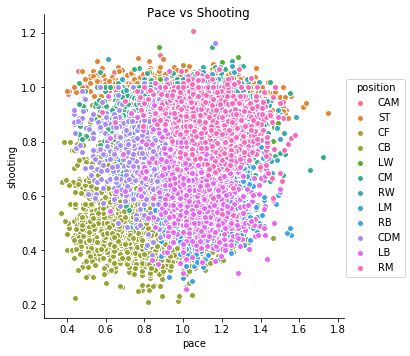

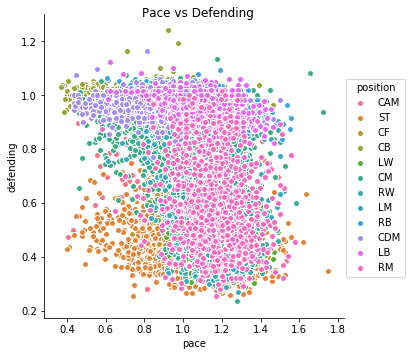

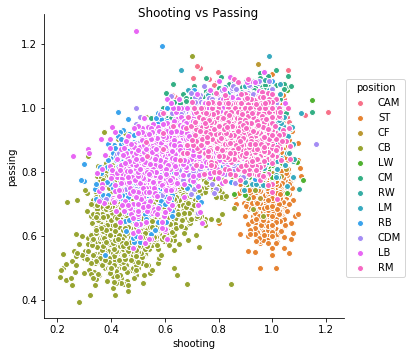

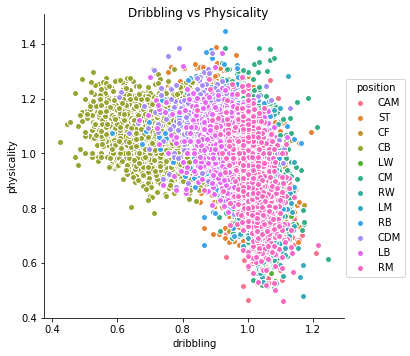

In [10]:
import seaborn as sns



fig1 = sns.pairplot(x_vars=["pace"], y_vars=["shooting"], data=df_players_normalized, hue="position", size=5)
fig1.fig.suptitle("Pace vs Shooting")

fig2 = sns.pairplot(x_vars=["pace"], y_vars=["defending"], data=df_players_normalized, hue="position", size=5)
fig2.fig.suptitle("Pace vs Defending")


fig3 = sns.pairplot(x_vars=["shooting"], y_vars=["passing"], data=df_players_normalized, hue="position", size=5)
fig3.fig.suptitle("Shooting vs Passing")


fig4 = sns.pairplot(x_vars=["dribbling"], y_vars=['physicality'], data=df_players_normalized, hue="position", size=5)
fig4.fig.suptitle("Dribbling vs Physicality")



For example, from the same figure we can see that defenders do not have pace and shooting, this is why they are on the left down corner.

Now, we have conditions to start estimate the parameters of our SVM model.

Bear in mind that the process of finding the best combination os parameters takes time, so here I am not trying that many combinations of parameters.

Here, GridSearch will try all combinations of paramaters and will decide the best one for us. If you want to change, you can try a different kernel, a different cost and gamma functions, and so on.

In [11]:

from sklearn import svm


from sklearn.model_selection import train_test_split, GridSearchCV



df_players = df_players_normalized[['position', 'pace', 'dribbling', 'shooting', 'passing', 'defending', 'physicality', 'pref_foot']]



# Split data to train and test on 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(df_players_normalized.loc[:, df_players_normalized.columns != 'position'], df_players_normalized['position'], test_size = 0.5, random_state=1)




tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.0001],
                     'C': [1000, 10000]}]



clf = GridSearchCV(svm.SVC(), tuned_parameters, cv = 2)




clf.fit(X_train, y_train)


# clf = grid.best_estimator_()
print("Best Parameters:\n", clf.best_params_)
print("Best Estimators:\n", clf.best_estimator_)

parameters = clf.best_params_

real, estimation = y_test, clf.predict(X_test)




Best Parameters:
 {'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Now, we can compare the predictions with the "real positions".

In [13]:
lst_positions = df_players_normalized.position.unique()



#creating a dataframe with the ocurrances
df_rel_freq = pd.DataFrame(index = lst_positions, columns = lst_positions)

df_rel_freq = df_rel_freq.fillna(0)


for i in range(len(estimation)):
    df_rel_freq.loc[real.iloc[i]].loc[estimation[i]] =  df_rel_freq.loc[real.iloc[i]].loc[estimation[i]] + 1



#our dataframe should be in percentage
df_rel_freq_pu = 100*(df_rel_freq.T/df_rel_freq.sum(axis=1)).T    


#just printing the dataframe
(df_rel_freq_pu)


,CAM,ST,CF,CB,LW,CM,RW,LM,RB,CDM,LB,RM
CAM,37.318841,9.601449,0.905797,0.000000,0.543478,21.739130,0.181159,13.224638,0.181159,0.000000,0.181159,16.123188
ST,2.162162,91.959459,0.000000,0.000000,0.135135,0.608108,0.000000,1.824324,0.067568,0.067568,0.000000,3.175676
CF,27.868852,39.344262,6.557377,0.000000,1.639344,3.278689,0.000000,13.114754,0.000000,0.000000,0.000000,8.196721
CB,0.000000,0.000000,0.000000,85.479798,0.000000,0.694444,0.000000,0.000000,4.545455,5.618687,3.661616,0.000000
LW,10.837438,23.645320,0.000000,0.000000,0.985222,7.881773,0.000000,20.197044,0.000000,0.000000,0.985222,35.467980
CM,2.746781,0.343348,0.000000,0.000000,0.000000,81.630901,0.000000,1.802575,2.317597,7.038627,3.090129,1.030043
RW,12.707182,19.337017,1.104972,0.000000,0.000000,4.972376,0.552486,20.441989,0.000000,0.000000,0.000000,40.883978
LM,12.589928,14.748201,0.000000,0.000000,0.000000,9.352518,0.179856,25.539568,0.899281,0.000000,3.057554,33.633094
RB,0.000000,0.000000,0.000000,4.565538,0.000000,10.309278,0.000000,0.000000,75.552283,8.983800,0.589102,0.000000
CDM,0.000000,0.000000,0.000000,10.608204,0.000000,23.055163,0.000000,0.000000,12.022631,48.090523,6.223479,0.000000


In the previous dataframe, the rows represents the real position and the columns are the estimations. For example, the Striker position (ST) got 92% of the guesses as ST. This means that onlu 8% of the strikers should be playing somewhere else on the pitch.

We can also see that some positions with that not many players could not be well estimated. For example, only 1 % of the LW were estimated as LW. The majority of them were estimated as LM and RM (it makes sense, right?).

Now, we can use our model to predict the postion of all players.

In [17]:
x,y = (df_players.loc[:, df_players.columns != 'position']), df_players['position']


clf = svm.SVC(kernel = parameters['kernel'], gamma = parameters['gamma'], C = parameters['C'])

clf.fit(x,y)


estimation = clf.predict(df_players.loc[:, df_players.columns != 'position'])

real = df_players['position']



#creating a dataframe showing the real position and the estimation for each player
df_players_compare = pd.DataFrame(columns = ['Name', 'Real Position', 'Suggested Position', 'overall', 'club'])

for i in range(len(estimation)):
    
    df_players_compare.loc[i] = [df_players_infos_add['player_name'].iloc[i], real.iloc[i], estimation[i], df_players_infos_add['overall'].iloc[i], df_players_infos_add['club'].iloc[i]]




In [18]:
df_players_compare

,Name,Real Position,Suggested Position,overall,club
0,Pelé,CAM,CAM,98,Icons
1,Maradona,CAM,CAM,97,Icons
2,Ronaldo,ST,ST,96,Icons
3,Pelé,CF,CAM,95,Icons
4,Maradona,CAM,CAM,95,Icons
5,Maldini,CB,CB,94,Icons
6,Ronaldo,ST,ST,94,Icons
7,Ronaldinho,LW,CAM,94,Icons
8,Van Basten,ST,ST,93,Icons
9,Matthäus,CM,CDM,93,Icons


There are interesting examples. For example, the player Maldini was a great CB, but he used to play as a LB at the start.

In [22]:
print('early age Maldini')
df_players_compare.iloc[85]



early age Maldini


Name                  Maldini
Real Position              LB
Suggested Position         CB
overall                    88
club                    Icons
Name: 85, dtype: object

In [23]:
print('Maldini')
df_players_compare.iloc[5]

Maldini


Name                  Maldini
Real Position              CB
Suggested Position         CB
overall                    94
club                    Icons
Name: 5, dtype: object

As we can see, even though his baby icon card was in the Left Back position, he was classified as a CB based on his stats.

This is not near perfect, since the size of each group is so different, specially when it comes to LW and RW. But, there are some insights that we can take from this experiment.